# Step 1: Brief description of the problem and data

This is a disaster tweet classification problem where I will build a model to predict which tweets are about real disasters and which ones are not. The data used came from the kaggle competition, 'Natural Language Processing with Disaster Tweets'.

In [9]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import re

import nltk 
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from tqdm import tqdm

from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input, SpatialDropout1D, Embedding, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.simplefilter(action='ignore', category=Warning)


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [11]:
# Reading train dataset
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')
subm_file = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

# Step 2: Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data

In [12]:
# Look at tweets that are about disasters
df_train[df_train['target'] == 1]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [13]:
# Look at tweets that are not about disasters
df_train[df_train['target'] == 0]

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,10837,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0
7587,10841,NaN,NaN,Sirens everywhere!,0


<AxesSubplot:xlabel='count', ylabel='target'>

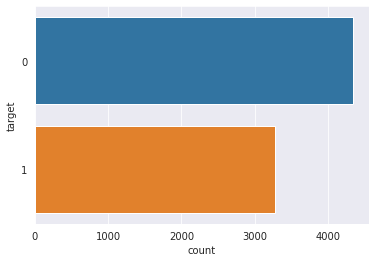

In [14]:
# Look at counts of tweets classified as disaster and tweets that were not
sns.countplot(y='target', data = df_train)

<AxesSubplot:>

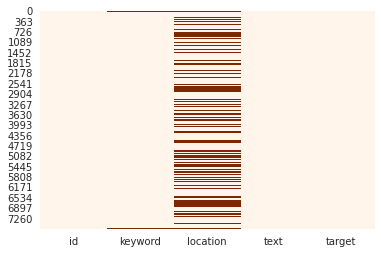

In [15]:
# see which columns have missing data.  I see both 'location' and 'keyword' columns have missing data.
sns.heatmap(df_train.isnull(),cbar=False,cmap='Oranges')

In [16]:
# checking to make sure only the 'location' and 'keyword' columns have nulls
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

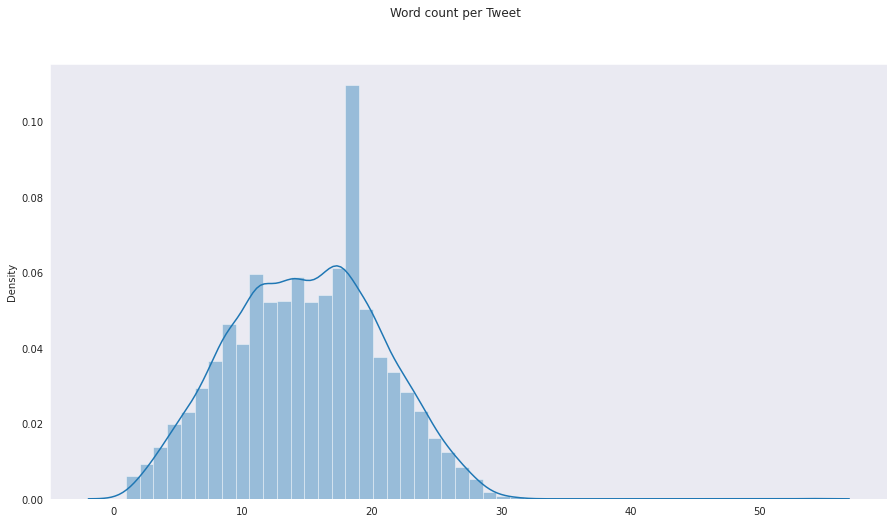

In [17]:
# Look at the word count per tweet
plt.figure(figsize=(15,8))
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split(" ")) )
sns.distplot(df_train['word_count'].values, hist=True)

plt.grid()
plt.suptitle("Word count per Tweet")
plt.show()

In [18]:
# Set text column as what we will use to predict whether a tweet is about a disaster or not
X = df_train["text"]

In [19]:
# Create a function to get all unique words in all tweets
def unique_words(sentence):
    unq_words_list = []
    for sent in tqdm(sentence):
        for word in sent.split():
            if word.lower() not in unq_words_list:
                unq_words_list.append(word.lower())
            else:
                pass
    return unq_words_list
unique_words = unique_words(X)
print("Total unique words present :",len(unique_words))

100%|██████████| 7613/7613 [00:11<00:00, 689.37it/s] 

Total unique words present : 27983


In [20]:
# let's look at the data quality of the words
unique_words[7600:7613]

['http://t.co/3ln8trhw6x',
 '#illinois:',
 'units',
 'simulate',
 'nu',
 'https://t.co/rd10ex6hvt',
 '@sharethis',
 '#hazmat',
 "fema's",
 'weeklong',
 'biological',
 'radioactive',
 'nuclear-biological-chemical']

As you can see above, there are links, strings that begin with '#' and strings that begin with '@' that we need to resolve.

In [22]:
# Check to see words or groups of characters start with '#'
SYMB_1 = "#"
sym1_words = [word for word in unique_words if word.startswith(SYMB_1)]
sym1_words[0:20] # a lot of the output below looks helpful (e.g. #earthquake, #wildfires)

['#earthquake',
 '#wildfires',
 '#alaska',
 '#rockyfire',
 '#cafire',
 '#flood',
 '#disaster',
 '#flooding',
 '#raining',
 '#florida',
 '#tampabay',
 '#tampa',
 '#we',
 '#breaking',
 '#metal',
 '#rt',
 '#africanbaze:',
 '#mufc',
 '#bridgetown',
 '#nsfw']

In [23]:
# Check to see words or groups of characters start with '@'
SYMB_2 = "@"
sym2_words = [word for word in unique_words if word.startswith(SYMB_2)]
sym2_words[0:20] # on the other hand, these groups of strings, we should delete from our dataset

['@bbcmtd',
 '@phdsquares',
 '@southridgelife',
 '@\x89û_',
 '@navista7',
 '@news24680',
 '@nxwestmidlands',
 '@ablaze',
 '@sleepjunkies:',
 '@your4state.',
 '@flowri',
 '@aftershock_delo',
 '@djicemoon',
 '@kjfordays',
 '@esquireattire',
 '@onfireanders',
 '@cod8sandscrims',
 '@empirikgaming',
 '@codawscrims',
 '@4tp_kotc']

In [30]:
# create a function to remove websites
def url_remove(text):
    url_patterns = re.compile(r'https?://S+|www.S+')
    return url_patterns.sub(r'', text)

In [34]:
# Create a function to preprocess text.  This function will do things like: 
# 1) convert words to lower case
# 2) use url remove function
# 3) remove words starting with '@'
wnl = WordNetLemmatizer() # lemmatize is taking a word and getting its simplest form (e.g. convert bicycles to bicycle)
def preprocess(text):
    tweets = []
    for sentence in tqdm(text):
        sentence = sentence.lower() # convert words to lower case
        sentence =  url_remove(sentence) # remove url from sentence
        sentence = re.sub(r'@w+',  '', sentence).strip() # remove words or strings that start with "@"
        sentence = re.sub("[^a-zA-Z0-9 ']", "", sentence) # remove symbols
        sentence = sentence.split()
        sentence1 = [wnl.lemmatize(word) for word in sentence if word not in set(stopwords.words("english"))]
        sentence1 = " ".join(sentence1)
        tweets.append(sentence1)
    return tweets
tweets = preprocess(X)

100%|██████████| 7613/7613 [00:15<00:00, 503.08it/s]


In [35]:
# Create a new column called tweets which will contain the preprocessed text
df_train['tweets'] = np.array(tweets)#tweets

In [36]:
# Look at the new train data set
df_train

,level_0,index,id,keyword,location,text,target,word_count,tweets
0,0,0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquake may allah forgive u
1,1,1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la ronge sask canada
2,2,2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,resident asked 'shelter place' notified office...
3,3,3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9,13000 people receive wildfire evacuation order...
4,4,4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...,...,...,...
7608,7608,7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,11,two giant crane holding bridge collapse nearby...
7609,7609,7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,20,ariaahrary thetawniest control wild fire calif...
7610,7610,7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj
7611,7611,7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,19,police investigating ebike collided car little...


In [37]:
# split the data set for training and testing
X_train, X_test,y_train, y_test = model_selection.train_test_split(df_train['tweets'],
                                                                   df_train['target'],
                                                                   test_size=0.3,
                                                                   random_state=0, 
                                                                   shuffle=True)

In [38]:
# Using CountVectorizer because I need to transform text into a vector by way of count of each word that occurs in the entire text
X_train_GBC = X_train.values.reshape(-1)
x_test_GBC = X_test.values.reshape(-1)
vectorizer = CountVectorizer()
X_train_GBC = vectorizer.fit_transform(X_train_GBC)
x_test_GBC = vectorizer.transform(x_test_GBC)

In [39]:
# Training the model using Gradient Boosting.  In Gradient Boosting, each predictor tries to improve on its predecessor by reducing the errors.
gbc_model = ensemble.GradientBoostingClassifier(learning_rate=0.1,                                            
                                            n_estimators=2000,
                                            max_depth=9,
                                            min_samples_split=6,
                                            min_samples_leaf=2,
                                            max_features=8,
                                            subsample=0.9)
gbc_model.fit(X_train_GBC, y_train)

GradientBoostingClassifier(max_depth=9, max_features=8, min_samples_leaf=2,
                           min_samples_split=6, n_estimators=2000,
                           subsample=0.9)

In [41]:
# Look at accuracy and the f-score
prediction = gbc_model.predict(x_test_GBC)

accuracy = metrics.accuracy_score(prediction, y_test)
print("Test accuracy: ", accuracy)
print(metrics.classification_report(y_test, prediction, target_names=["0", "1"]))
print("Test F-score: ", metrics.f1_score(y_test, prediction))

Test accuracy:  0.8007880910683012
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1338
           1       0.82      0.66      0.73       946

    accuracy                           0.80      2284
   macro avg       0.81      0.78      0.79      2284
weighted avg       0.80      0.80      0.80      2284

Test F-score:  0.7331378299120235


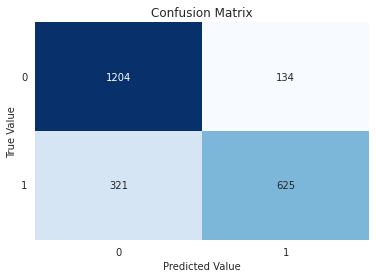

In [45]:
# Look at the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, prediction)

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix, cbar=False, cmap='Blues', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)

plt.show()

# Step 3: Model Architecture

With the Gradient Boosting model, the f score is 0.73.  Let's see if we can do better with a deep learning model.

In the deep learning model, I will add the following:

- the batch size will be 32 because this is a power of 2 and will help my model run more efficiently.
- I will also use sigmoid activation because I want my values to be between 0 and 1 as well.
- I will use the relu activation function because it will make my model easier to train and help with better performance
- I will use embedding because it is useful on large inputs like sparse vectors representing words
- Dropout of 0.2 and 0.5 (20% to 50% is recommended). 
- Batch Normalization – it improves the learning speed of Neural Networks and provides regularization, avoiding overfitting.
- Using Adam optimizer. Unlike maintaining a single learning rate through training in SGD, Adam optimizer updates the learning rate for each network individually

In [49]:
# I need to convert words in tweets to numbers so we can use in our model
VOC_SIZE = 30000 # defining the vocabulary size # started with 30000
onehot_vector = [one_hot(words, VOC_SIZE) for words in tweets]
onehot_vector[0:5] # the output below shows the index for each word in each tweet

[[6055, 20285, 6512, 15381, 26705, 24380, 24989],
 [24497, 15688, 23683, 6285, 8006, 25356, 27482],
 [16290, 29611, 11555, 10472, 17929, 16895, 2202, 21323, 18591, 27234, 264],
 [12129, 16606, 13791, 13800, 2202, 27234, 20546],
 [2361, 17139, 18347, 29356, 4446, 13624, 13800, 18882, 10805]]

In [50]:
# to improve the quality of the model, sequences need to be of the same size
SENTENCE_LENGTH = 15 # declaring size of sentence as 15, was 15 now 20
embedded_docs = pad_sequences(onehot_vector, padding="post", maxlen=SENTENCE_LENGTH)
embedded_docs # the output below now shows each tweet having the same size

array([[ 6055, 20285,  6512, ...,     0,     0,     0],
       [24497, 15688, 23683, ...,     0,     0,     0],
       [16290, 29611, 11555, ...,     0,     0,     0],
       ...,
       [10592, 20341, 18490, ...,     0,     0,     0],
       [18374, 15456,  4033, ..., 28092, 18122,     0],
       [17017,  5562, 10279, ...,     0,     0,     0]], dtype=int32)

In [51]:
# Create Bidirectional deep learning model
def dl_model():
    VECTOR_FEATURES = 32
    lstm_model = Sequential()
    lstm_model.add(Embedding(VOC_SIZE, VECTOR_FEATURES, input_length=SENTENCE_LENGTH))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Bidirectional(LSTM(256)))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(512, activation="relu"))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(BatchNormalization())
    lstm_model.add(Dense(1, activation = "sigmoid"))
    return lstm_model

In [52]:
# Looking at the summary of my model which includes the amount of non-trainable parameters
dl_model = dl_model()
dl_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
dl_model.summary() #summary

2022-11-21 20:10:41.395840: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 32)            960000    
_________________________________________________________________
dropout (Dropout)            (None, 15, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               591872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2

In [53]:
# Setting up my dependent variable and then fit x and y to my model
y = df_train["target"] # dependent feature
y = np.array(y) # converting to array
history = dl_model.fit(embedded_docs, y, epochs=11, batch_size=32)

2022-11-21 20:10:50.763611: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/11
238/238 [==============================] - 18s 62ms/step - loss: 0.5476 - accuracy: 0.7217
Epoch 2/11
238/238 [==============================] - 14s 60ms/step - loss: 0.3221 - accuracy: 0.8698
Epoch 3/11
238/238 [==============================] - 15s 62ms/step - loss: 0.1827 - accuracy: 0.9324
Epoch 4/11
238/238 [==============================] - 14s 60ms/step - loss: 0.1163 - accuracy: 0.9603
Epoch 5/11
238/238 [==============================] - 15s 62ms/step - loss: 0.0821 - accuracy: 0.9716
Epoch 6/11
238/238 [==============================] - 14s 59ms/step - loss: 0.0618 - accuracy: 0.9817
Epoch 7/11
238/238 [==============================] - 14s 58ms/step - loss: 0.0516 - accuracy: 0.9853
Epoch 8/11
238/238 [==============================] - 14s 60ms/step - loss: 0.0468 - accuracy: 0.9886
Epoch 9/11
238/238 [==============================] - 14s 57ms/step - loss: 0.0335 - accuracy: 0.9907
Epoch 10/11
238/238 [==============================] - 14s 61ms/step - loss: 0.034

Text(0.5, 1.0, 'Accuracy')

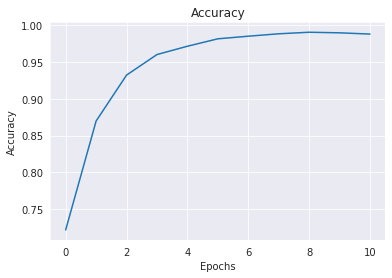

In [54]:
# Plot the accuracy across Epochs
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")

Text(0.5, 1.0, 'Loss')

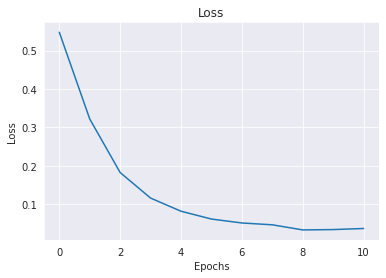

In [55]:
# Plot the loss across Epochs
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")

## Prep file for submission using test data

In [56]:
# Set text column as what we will use to predict whether a tweet is about a disaster or not
X_test = df_test["text"]

In [57]:
# Preprocessing text
tweets2 = preprocess(X_test)

100%|██████████| 3263/3263 [00:05<00:00, 571.21it/s]


In [58]:
# I need to convert words in tweets to numbers so we can use in our model
onehot_vector2 = [one_hot(words, VOC_SIZE) for words in tweets2]

In [59]:
# to improve the quality of the model, sequences need to be of the same size
embedded_docs2 = pad_sequences(onehot_vector2, padding="post", maxlen=SENTENCE_LENGTH)
embedded_docs2

array([[28521, 17028, 25129, ...,     0,     0,     0],
       [21329,  6512, 13564, ...,     0,     0,     0],
       [24497, 15688,  8973, ...,     0,     0,     0],
       ...,
       [ 7188, 21289,  1030, ...,     0,     0,     0],
       [ 3244,  9287,  2495, ...,     0,     0,     0],
       [ 6547,  8938, 24076, ...,     0,     0,     0]], dtype=int32)

In [60]:
# Put a new explanatory variable into our trained model
y_pred = dl_model(embedded_docs2)
y_pred.shape

TensorShape([3263, 1])

In [62]:
# For the predicted output, I need to convert the data to show simply 0s and 1s or 'no disaster tweet' and 'disaster tweet', respectively
y_pred_class = []
for item in y_pred:
    if item[0] >=0.5:
        y_pred_class.append(1)
    else:
        y_pred_class.append(0)  

In [63]:
# Just looking at the output to make sure I only have 0s and 1s
print(y_pred_class[0:10])

[1, 0, 1, 1, 1, 1, 0, 0, 0, 0]


In [64]:
# Prepare the data for submission
sample_data = dict(id = df_test.id, target = y_pred_class)
sample_df = pd.DataFrame(sample_data)
sample_df.head(n=20)

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [43]:
# Submit my file for the competition
sample_df.to_csv("submission.csv",index= False)

# Step 4: Results and Analysis

Using the deep learning model, my f-score improved from 0.72 to 0.76.  I did change the hyperparameters in order to improve the deep learning model.  I also changed from a LSTM model to a Bidirectional model.  Also, to increase my f-score, I changed how I preprocessed data.  Originally, I did not exclude words that started with '@' but with the code above, I did remove those strings.

# Step 5: Conclusion

After changing preprocessing techiques, changing models, tuning hyperparameters, I have a good f-score of 0.76.  I was hoping to get a higher score but for this assignment, I think this is a good start, using a deep learning model.